In [1]:
import glob,os
import numpy as np
import pandas as pd
from fitsio import FITS
import re

# import astropy
from astropy.table import Table, setdiff, vstack,join

import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

h = 0.71
file_path = r"/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/Data/"

# cluster_halos_red = pd.read_pickle(file_path + 'halos/halos_redmapper_withh_mthd2.csv')

# Load Halos data with Weak lensing profiles

In [2]:
# ## Sigma and DS profile
# sigma_ds_profile = pd.read_pickle(file_path + 'WL-Signal/skysim-full-DS_S-2152757.csv')
# print(len(sigma_ds_profile))
# sigma_ds_profile[:3]

In [3]:
## Sigma and DS profile
sigma_ds_profile_old = pd.read_pickle(file_path + 'WL-Signal/skysim-full-2152757-1.1.1.csv')
sigma_ds_profile_old = sigma_ds_profile_old[['halo_id', 'radius', 'sigma', 'DS', 'ra','dec','baseDC2/sod_halo_mass','redshift']]
print(len(sigma_ds_profile_old))
sigma_ds_profile_old = sigma_ds_profile_old[sigma_ds_profile_old['baseDC2/sod_halo_mass']>0]
print(len(sigma_ds_profile_old))
sigma_ds_profile_old[:3]

2152757
2149934


halo_id                                             radius  \
0  21510052411  [0.11625478705692514, 0.21482457658477289, 0.3...   
1  27910052411  [0.12314233583981647, 0.1946385019593716, 0.33...   
2  33810052411  [nan, 0.20168449252984735, 0.3338147296733549,...   

                                               sigma  \
0  [78612834141880.81, 14933447677748.465, 784974...   
1  [69137409498569.67, 18537356311081.613, -83061...   
2  [nan, 33861894111106.793, -5767578407861.902, ...   

                                                  DS         ra        dec  \
0  [23464216793084.758, 45369716100550.74, 223461...  11.097545 -40.131041   
1  [20005037864612.92, 36060834738498.14, 1456097...  10.412447 -40.455208   
2  [nan, 25678358976517.617, 11424558927322.535, ...  11.115452 -39.923554   

   baseDC2/sod_halo_mass  redshift  
0           4.926635e+12  0.203337  
1           7.011123e+12  0.207353  
2           8.982885e+12  0.204473

# Load cluster-halos matched (RedMaPPer)

In [4]:
cluster_halos_red = pd.read_pickle(file_path + 'halos/halos_redmapper_withh_mthd2.csv')
cluster_halos_red = pd.merge(cluster_halos_red,sigma_ds_profile_old, on='halo_id', how='left')
cluster_halos_red = cluster_halos_red[cluster_halos_red['redshift_y']<=0.95]
cluster_halos_red = Table.from_pandas(cluster_halos_red)
# cluster_halos_red = Table(join(sigma_ds_profile,cluster_halos_red, keys_right=['halo_id','m200'],keys_left=['haloid','Mvir']))
print(len(cluster_halos_red))
cluster_halos_red[:2]

35595


<Table length=2>
cluster_id      richness     ... baseDC2/sod_halo_mass_y      redshift_y    
  int64         float64      ...         float64               float64      
---------- ----------------- ... ----------------------- -------------------
      9433 49.79644775390625 ...        97933961723904.0 0.26917436695288965
      7477 45.35725402832031 ...       442353043111936.0  0.9469373664174245

# Lets compute the error bars 

In [5]:
import matplotlib.cm as cm
npatch = 100
colors = cm.rainbow(np.linspace(0, 1, npatch))
np.random.shuffle(colors)

In [6]:
from astropy.coordinates import SkyCoord
cluster_halos_red['ra_y'] = cluster_halos_red['ra_y'] - 360 * (cluster_halos_red['ra_y'] > 180) 
ra_rad = cluster_halos_red['ra_y'] * (np.pi / 180.0 )  # Convert to radians
dec_rad = cluster_halos_red['dec_y'] * (np.pi / 180.0 )
# Most codes don't know anything about Ra, Dec, so convert to x,y,z on unit sphere.
sky_coord = SkyCoord(ra=ra_rad, dec=dec_rad, unit='radian')

# Extract x, y, z coordinates from the SkyCoord object
x = sky_coord.cartesian.x.value
y = sky_coord.cartesian.y.value
z = sky_coord.cartesian.z.value
xyz = np.array([x, y, z]).T

In [7]:
# Used scipy version 1.2.1
import scipy
import time
from scipy.cluster.vq import kmeans, vq
t0 = time.time()
xyz = np.array([x, y, z]).T
cen, distortion = kmeans(xyz, npatch)
scipy_labels = vq(xyz, cen)[0]
t1 = time.time()
scipy_time = t1-t0
print('Time = ',t1-t0)

Time =  6.817945718765259


In [8]:
cluster_halos_red['patch_label'] = scipy_labels

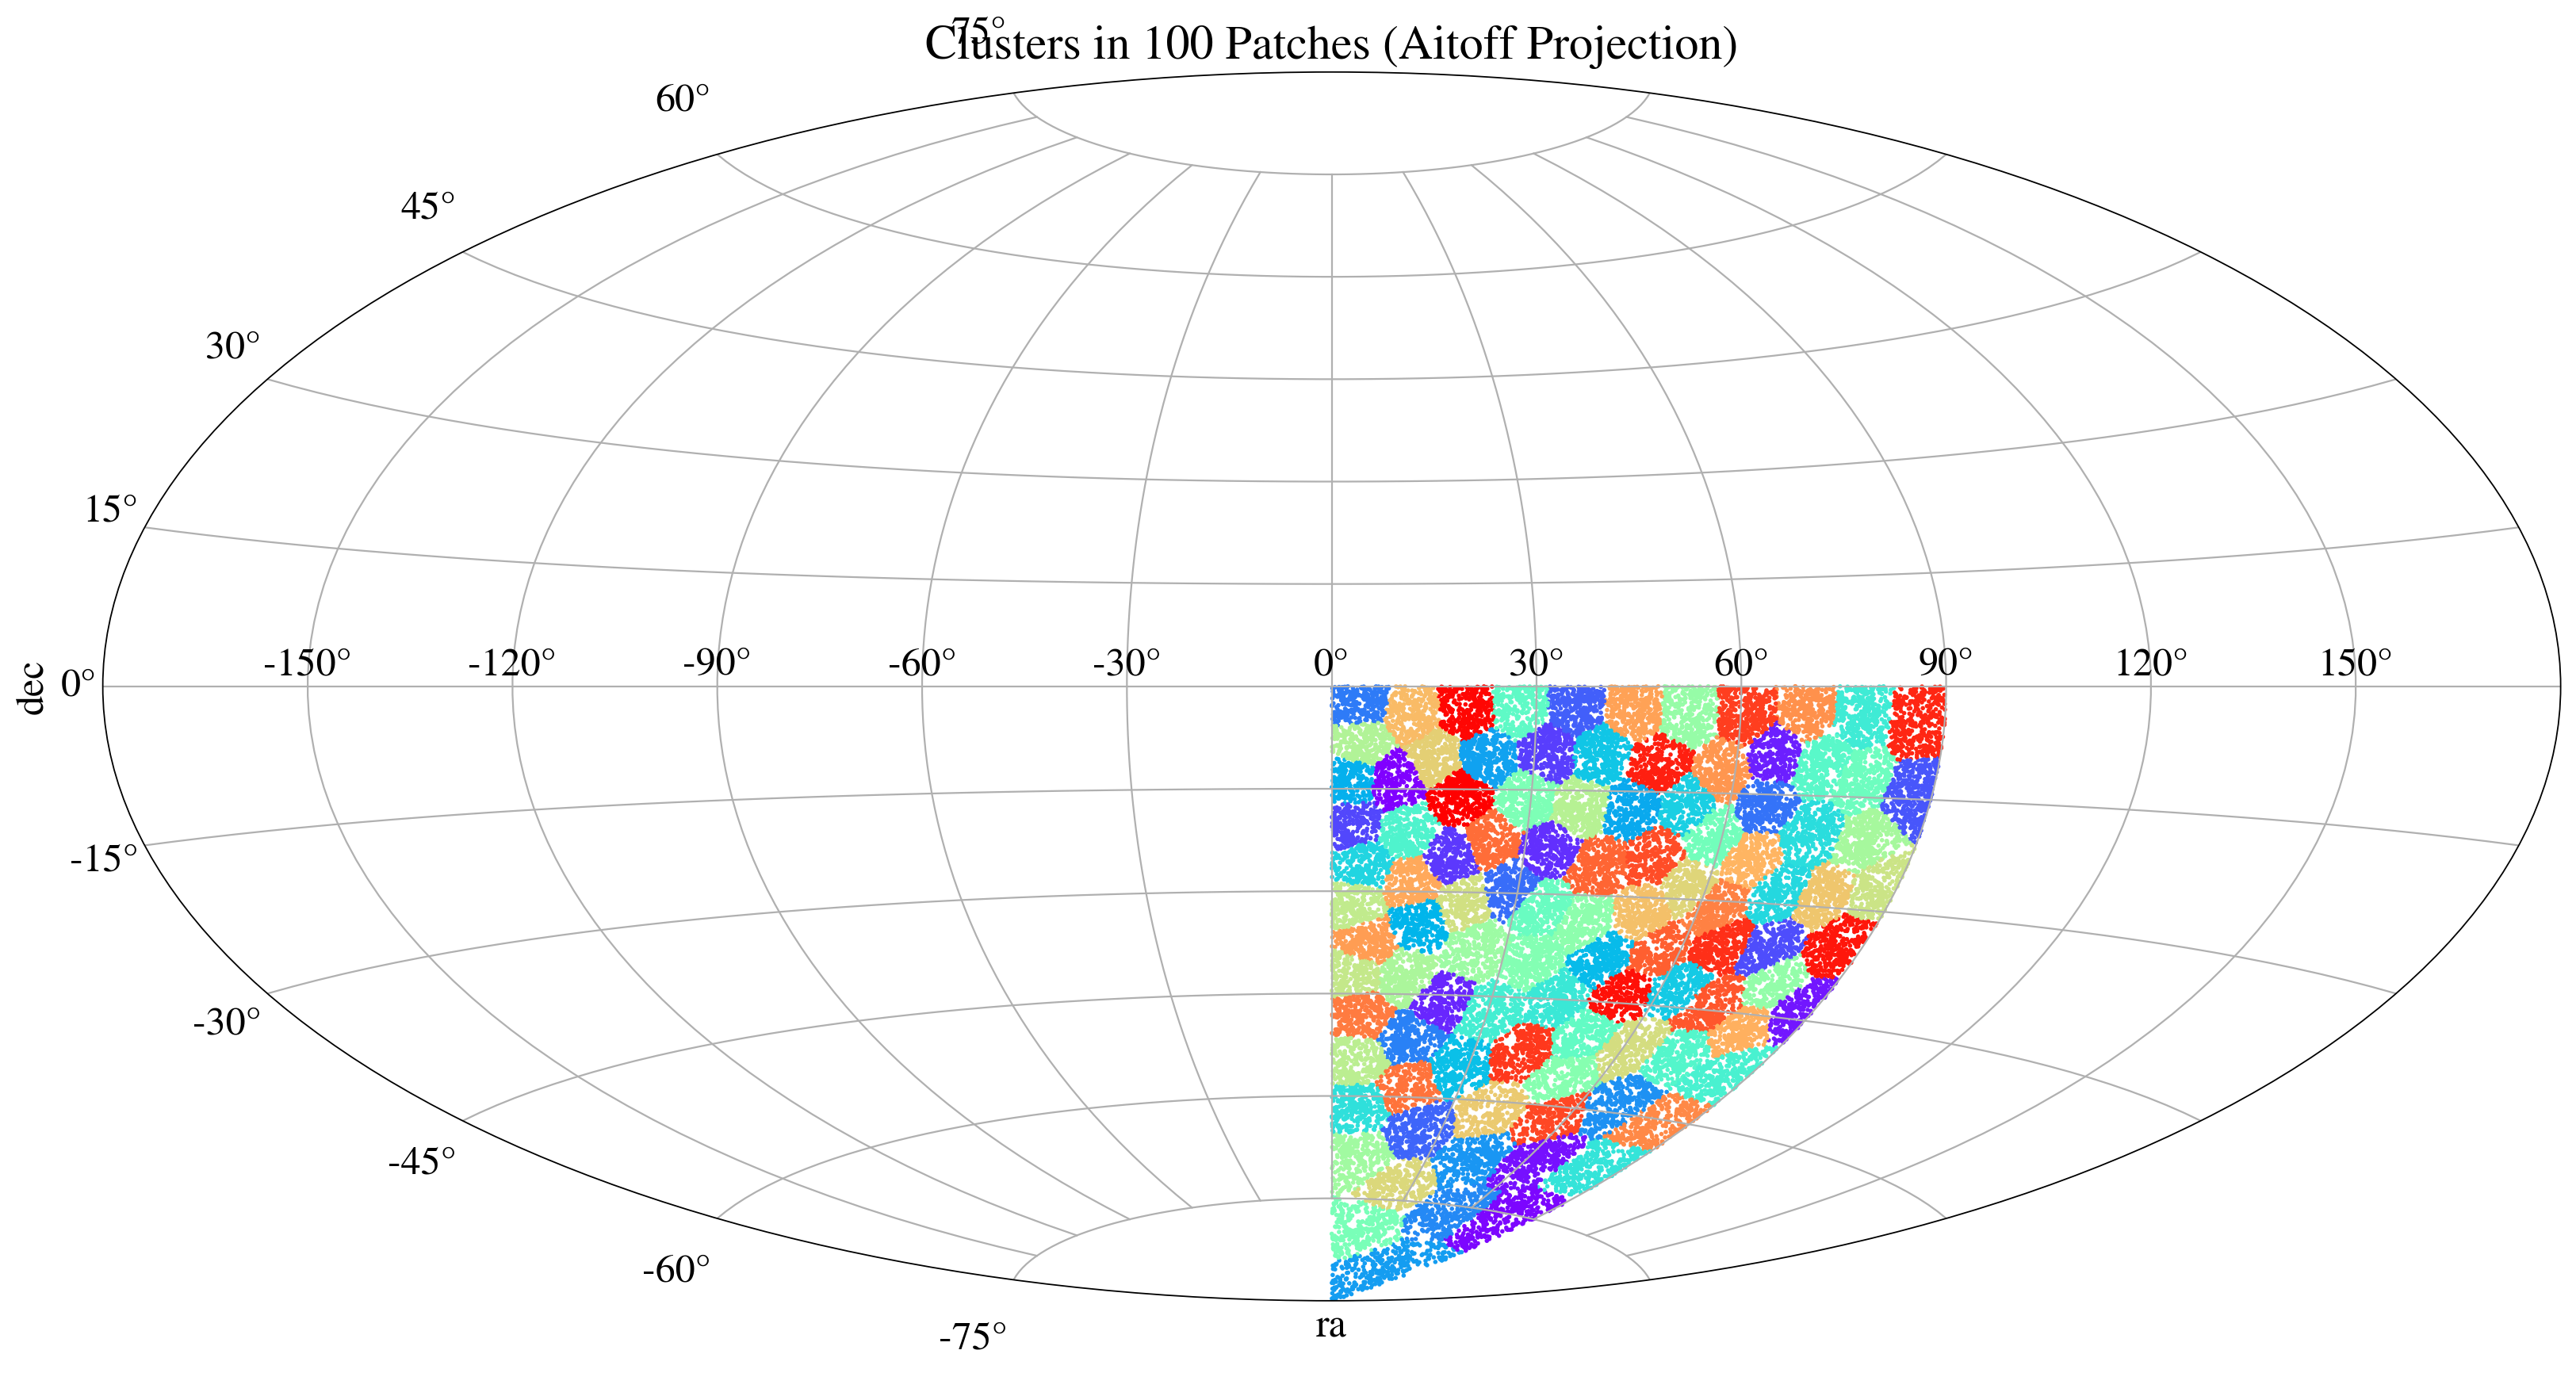

In [9]:
### ra and dec as the coordinate field names
plt.figure(figsize=(20, 15))
plt.subplot(projection="aitoff")
plt.scatter(ra_rad, dec_rad, color=colors[scipy_labels],s=1)

plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Clusters in 100 Patches (Aitoff Projection)')
plt.grid(True)
plt.show()

In [10]:
cluster_halos_red['lambda_range'] = pd.cut(cluster_halos_red['richness'], bins=[20, 30, 45, 60, np.inf], labels=['(20,30]', '(30,45]', '(45,60]', '(60,$\inf$]'])
cluster_halos_red['z_range'] = pd.cut(cluster_halos_red['redshift_y'], bins=[0.2, 0.35, 0.5, 0.65, 0.8, 0.95], labels=['(0.2,0.35]', '(0.35,0.5]', '(0.5,0.65]','(0.65,0.8]','(0.8,0.95]'])

grouped_cl_halos_red = cluster_halos_red.group_by([ 'z_range', 'lambda_range'])

cluster_halos_red[:2]

<Table length=2>
cluster_id      richness            dec_x        ... lambda_range  z_range  
  int64         float64            float64       ...    object      object  
---------- ----------------- ------------------- ... ------------ ----------
      9433 49.79644775390625 -16.994632637549927 ...      (45,60] (0.2,0.35]
      7477 45.35725402832031 -23.195630365738808 ...      (45,60] (0.8,0.95]

In [11]:
from astropy.table import QTable
from scipy.stats import sem

# Create an empty Astropy QTable to store error bar result
error_table = QTable(names=[ 'z_range', 'lambda_range','radius', 'mean', 'sem'],
                     dtype=['S10', 'S10', 'f8','f8', 'f8'])

radius_values = []
mean_deltasigma_values = []
sem_deltasigma_values = []

# Iterate over each group in reversed order
for lambda_group in grouped_cl_halos_red.groups:
    jackknife_sem = []
    jackknife_means = []
    jackknife_r = []
    # Perform jackknife leave-out approach
    for cluster_label in np.unique(scipy_labels):  # Assuming 'scipy_labels' is defined elsewhere
        # Leave out data points belonging to the current cluster label
        jackknife_sample = lambda_group[lambda_group['patch_label'] != cluster_label]
        jackknife_sem.append(np.std(jackknife_sample['DS_y'], axis=0, ddof=1)/np.sqrt(len(jackknife_sample['DS_y'])))
        jackknife_means.append(np.mean(jackknife_sample['DS_y'], axis=0))
        jackknife_r.append(np.mean(jackknife_sample['radius_y'], axis=0))
    
    mean_deltasigma_values.append(np.mean(jackknife_means, axis=0))
    sem_deltasigma_values.append(np.mean(jackknife_sem, axis=0))
    radius_values.append(np.mean(jackknife_r, axis=0))
    
    # Append results to the error table
    error_table.add_row({'z_range': lambda_group['z_range'][0],
                         'lambda_range': lambda_group['lambda_range'][0]})

# Set the values for 'mean_deltasigma' and 'std_deltasigma' columns
error_table['mean'] = np.array(mean_deltasigma_values)
error_table['sem'] = np.array(sem_deltasigma_values)
error_table['radius'] = np.array(radius_values)
# Display the error table
error_table

# np.save(file_path+'error-skysim/DS-sem_Errorbars.npy', error_table)

<QTable length=20>
 z_range   lambda_range ...         mean [15]                   sem [15]        
 bytes10     bytes11    ...          float64                    float64         
---------- ------------ ... -------------------------- -------------------------
(0.2,0.35]      (20,30] ...                 nan .. nan                nan .. nan
(0.2,0.35]      (30,45] ...                 nan .. nan                nan .. nan
(0.2,0.35]      (45,60] ...                 nan .. nan                nan .. nan
(0.2,0.35]  (60,$\inf$] ...                 nan .. nan                nan .. nan
(0.35,0.5]      (20,30] ...   nan .. 155178270201.9249  nan .. 77370631977.62526
(0.35,0.5]      (30,45] ...  nan .. 183029945261.78262  nan .. 107451823986.3664
(0.35,0.5]      (45,60] ...                 nan .. nan                nan .. nan
(0.35,0.5]  (60,$\inf$] ...  nan .. -84972798302.17436 nan .. 167914466865.39377
(0.5,0.65]      (20,30] ... nan .. -12799950121.371122   nan .. 72881641742.3338
(0.5,0.65]      (30,45] ...  nan .. 66920809905.196144 nan .. 100023124043.82527
(0.5,0.65]      (45,60] ...   nan .. 184388799990.2906 nan .. 169647603219.75552
(0.5,0.65]  (60,$\inf$] ...  nan .. 259122048567.65558 nan .. 161318540564.54376
(0.65,0.8]      (20,30] ...   nan .. 215926191473.2171  nan .. 84167283989.73412
(0.65,0.8]      (30,45] ...   nan .. 56644082909.26232 nan .. 118953137949.53787
(0.65,0.8]      (45,60] ...   nan .. 281010488609.4745 nan .. 196085760023.97394
(0.65,0.8]  (60,$\inf$] ...  nan .. 155680236380.09344  nan .. 209303647405.0126
(0.8,0.95]      (20,30] ...  nan .. -9959294961.701683 nan .. 121136030787.64578
(0.8,0.95]      (30,45] ...  nan .. 173872800420.26697  nan .. 163058711091.3361
(0.8,0.95]      (45,60] ...  nan .. -78998487868.94275  nan .. 284673118742.7684
(0.8,0.95]  (60,$\inf$] ...  nan .. 228808687373.45804  nan .. 316353545949.7285

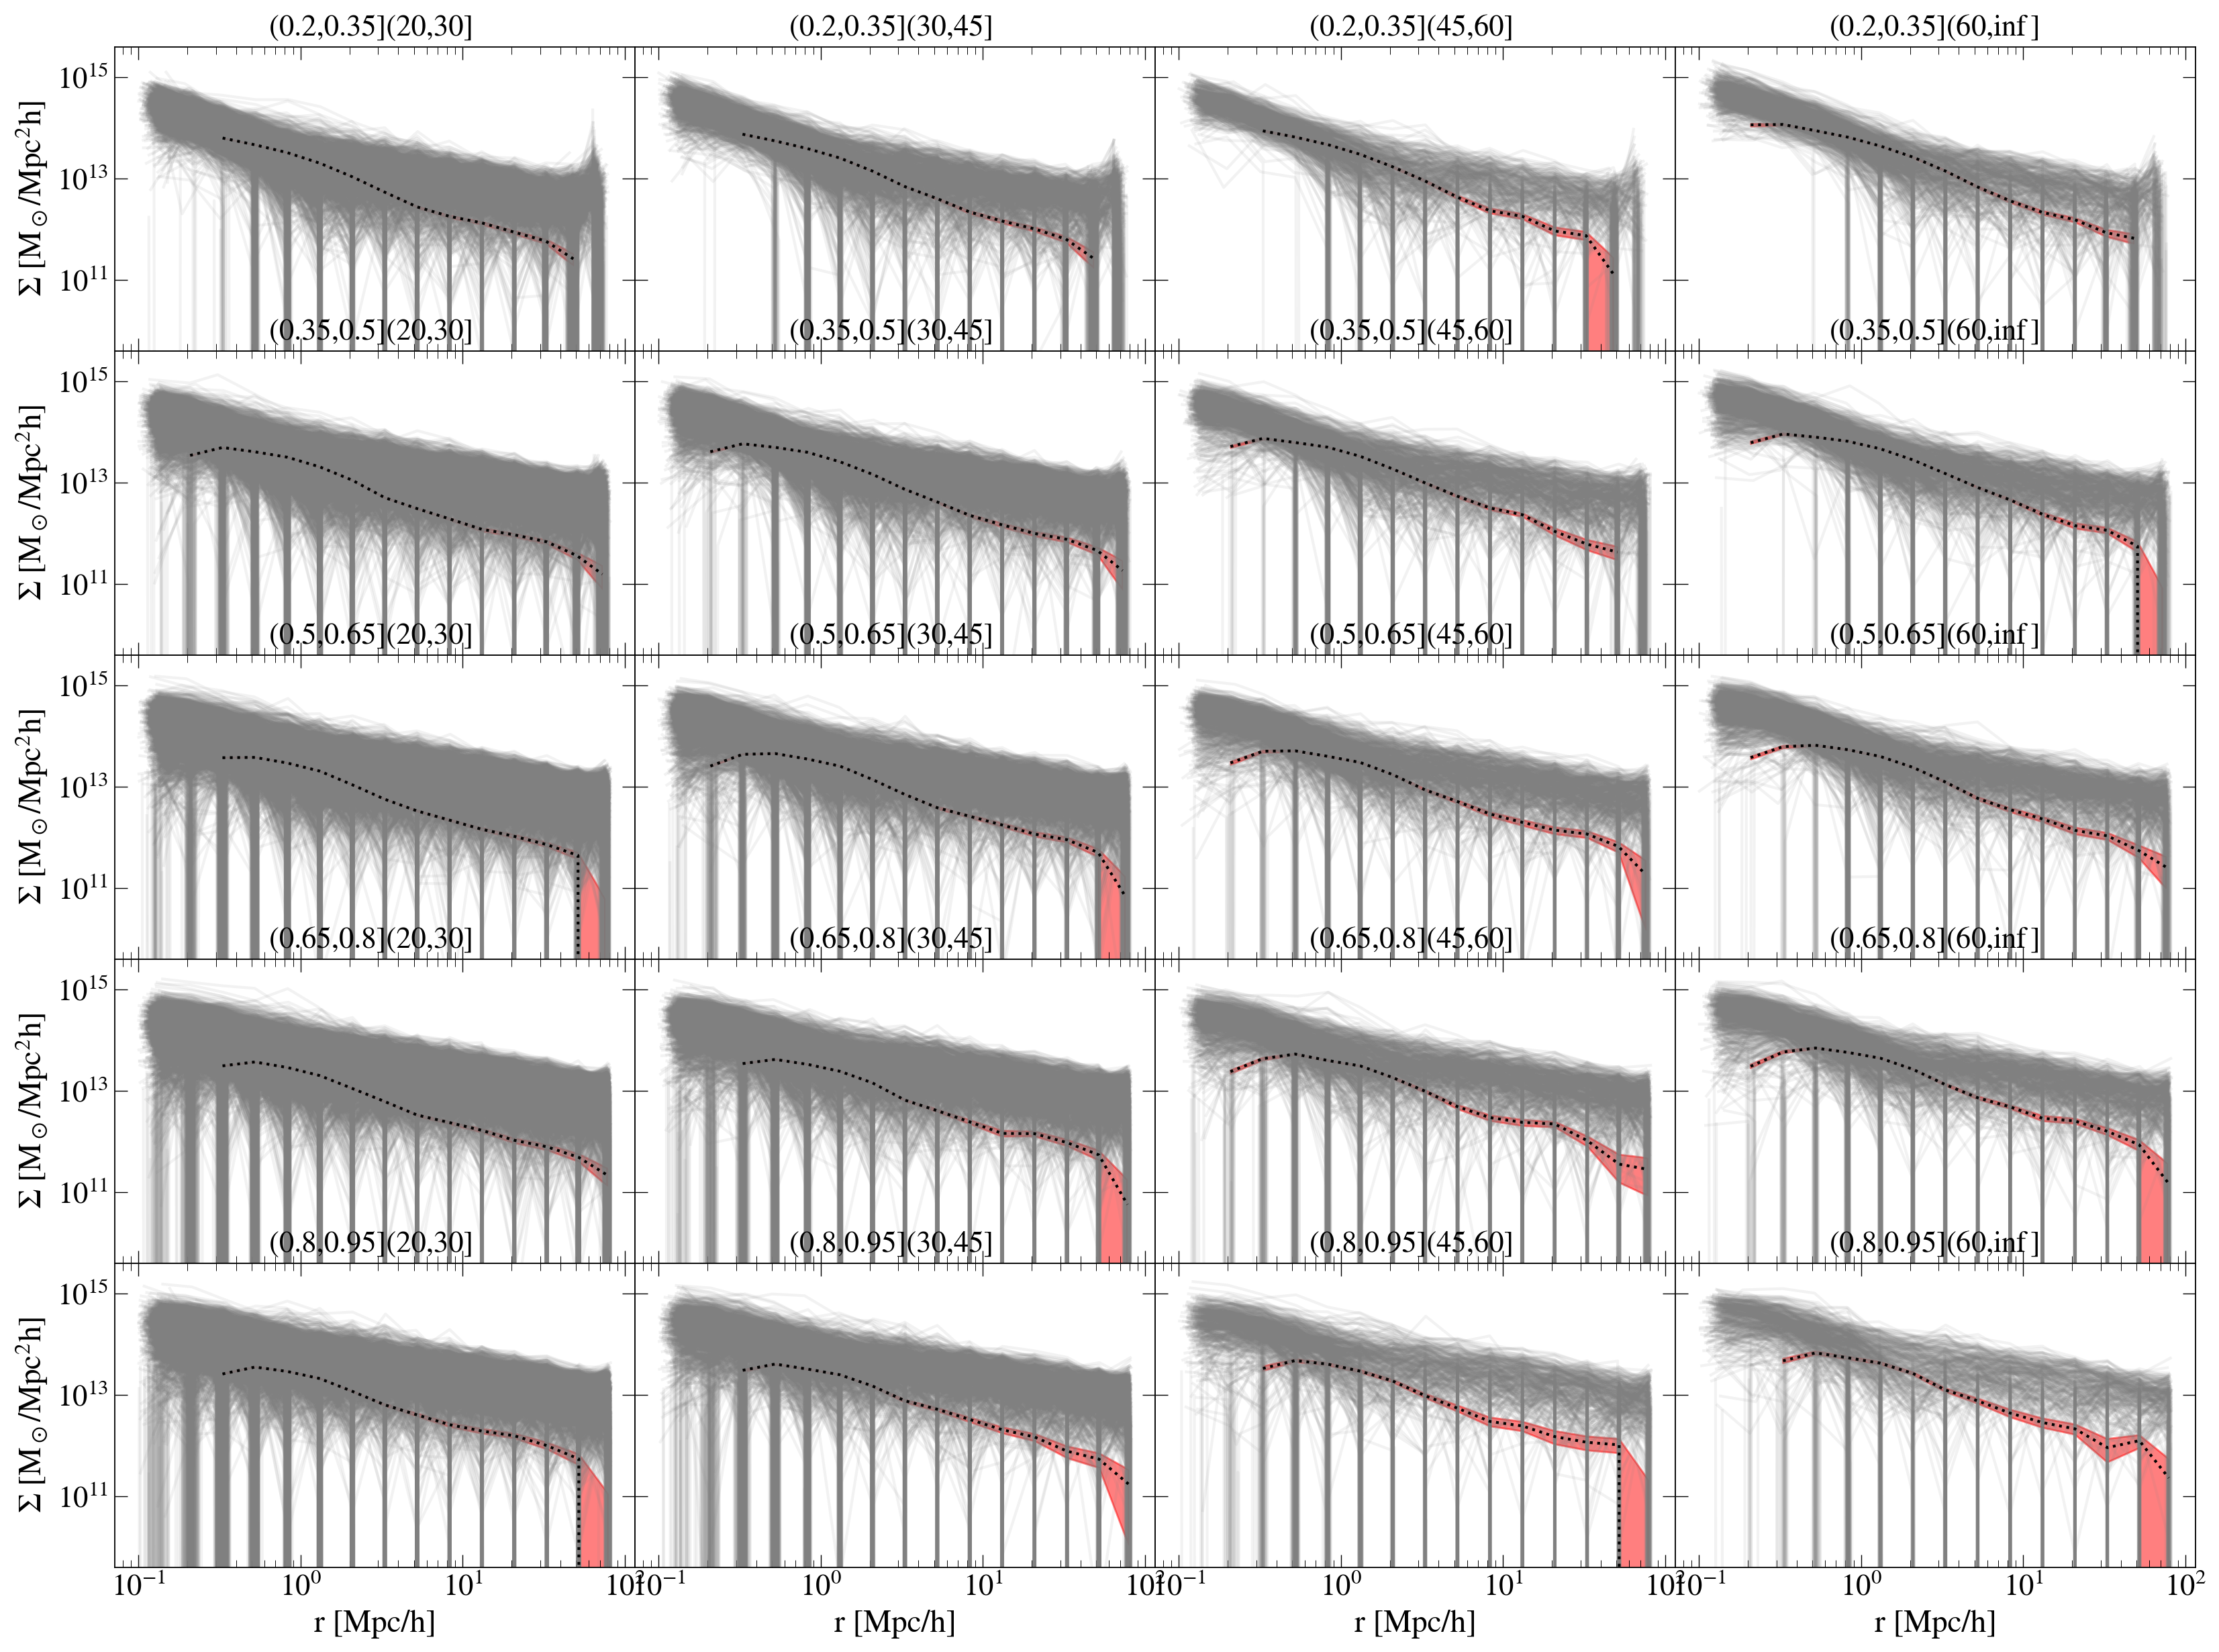

In [12]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20, 15), sharex=True, sharey=True)

# Flatten the subplot axes for easier iteration
axs = axs.flatten()

for ax in axs:   
    ax.tick_params(axis='both', which='major', labelsize=16)

for i in range(len(error_table)):   
    lambda_range = error_table['lambda_range'][i]
    z_range = error_table['z_range'][i]
    
    clusters = cluster_halos_red[(cluster_halos_red['lambda_range']==lambda_range) & (cluster_halos_red['z_range']==z_range)]
    # Plotting error bars on the current subplot
    for cl in range(len(clusters)):
        axs[i].plot(clusters['radius_y'][cl], clusters['sigma_y'][cl], alpha=0.1, color='gray')
    
    axs[i].plot(error_table['radius'][i], error_table['mean'][i], color='k', linestyle=':')
    # axs[i].fill_between(bins, error_table_sem['mean'][i]-error_table_sem['sem'][i], error_table_sem['mean'][i]+error_table_sem['sem'][i], alpha=0.5,color='red')
    
    # axs[i].errorbar(error_table['radius'][i], error_table['mean'][i], yerr=error_table['sem'][i], color='red')
    axs[i].fill_between(error_table['radius'][i], error_table['mean'][i]-error_table['sem'][i], error_table['mean'][i]+error_table['sem'][i], alpha=0.5,color='red')
    axs[i].set_title(f'{z_range}{lambda_range} ', fontsize=16)
    axs[i].set_xlabel('r [Mpc/h]', fontsize=17)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(False)

       # Show y-label only on the leftmost subplots
    if i % 4 == 0:
        axs[i].set_ylabel('$\Sigma ~[\mathrm{M}_\odot/\mathrm{Mpc}^2 \mathrm{h}]$', fontsize=17)
#         axs[i].yaxis.set_label_coords(-0.15, -0.5)  # Adjust label position

# Adjust layout and show the plot
plt.subplots_adjust(hspace=0, wspace=0)

plt.show()

## Load the Covariance matrix computed by Gladys

In [4]:
ds_err = Table(np.load(file_path+"error-skysim/DS-sem_Errorbars.npy"))
print(len(ds_err))
s_err = Table(np.load(file_path+"error-skysim/sigma-sem_Errorbars.npy"))
print(len(s_err))
s_err

20
20


<Table length=20>
 z_range   lambda_range ...         mean [15]                  sem [15]        
 bytes10     bytes11    ...          float64                   float64         
---------- ------------ ... ------------------------- -------------------------
(0.2,0.35]      (20,30] ...                nan .. nan                nan .. nan
(0.2,0.35]      (30,45] ...                nan .. nan                nan .. nan
(0.2,0.35]      (45,60] ...                nan .. nan                nan .. nan
(0.2,0.35]  (60,$\inf$] ...                nan .. nan                nan .. nan
(0.35,0.5]      (20,30] ... nan .. 1385269297570.8667 nan .. 112227568743.73293
(0.35,0.5]      (30,45] ...  nan .. 1462101660827.724 nan .. 154983148532.98807
(0.35,0.5]      (45,60] ...                nan .. nan                nan .. nan
(0.35,0.5]  (60,$\inf$] ... nan .. 1588028824289.0706 nan .. 234082031663.07452
(0.5,0.65]      (20,30] ... nan .. 2367260342811.2915 nan .. 104203863170.54494
(0.5,0.65]      (30,45] ...  nan .. 2197477286547.337 nan .. 140431720197.41165
(0.5,0.65]      (45,60] ...  nan .. 2029387811037.185 nan .. 240022979987.64853
(0.5,0.65]  (60,$\inf$] ... nan .. 2090965266581.7712 nan .. 242164097407.57938
(0.65,0.8]      (20,30] ... nan .. 3901648488666.9287 nan .. 117371240040.01785
(0.65,0.8]      (30,45] ... nan .. 4058296290580.9663 nan .. 165167342367.94116
(0.65,0.8]      (45,60] ... nan .. 3582994729407.9907 nan .. 272283872441.21164
(0.65,0.8]  (60,$\inf$] ...  nan .. 3626396120492.737  nan .. 304036391721.7498
(0.8,0.95]      (20,30] ...   nan .. 5821647784691.42 nan .. 169695760517.87097
(0.8,0.95]      (30,45] ...  nan .. 5966704695503.124 nan .. 232074217307.17465
(0.8,0.95]      (45,60] ...  nan .. 5489927235449.054 nan .. 397639682957.76086
(0.8,0.95]  (60,$\inf$] ...  nan .. 5945022575180.804  nan .. 453617879228.7028

In [5]:
## Weighted Profile
def stacked_profile_weighted_by_mass_redshift(lnM_select, z_select, prof_select, lnM_all, z_all, profile_A, dm=0.1, dz=0.05):
    #### set up the bins for mass and redshift  (sigma_select/profile_select, sigma_all/profile_all)
    min_m = min(lnM_select)#-dm
    max_m = max(lnM_select)#+dm
    min_z = min(z_select)#-dz
    max_z = max(z_select)#+dz

    # print('z', min_z, max_z)
    m_bins = np.arange(min_m, max_m+dm, dm)
    z_bins = np.arange(min_z, max_z+dz, dz)
    nM = len(m_bins)-1
    nz = len(z_bins)-1
    # print('nM, nz', nM, nz)

    profile_select = np.array([i.tolist() for i in prof_select])
    profile_all = np.array([i.tolist() for i in profile_A])

    nr = np.shape(profile_select)[1]#rbp.nbins_phys_mpc...1
    profile_weighted = np.zeros(nr)
    weight_norm = 0


    pdf1_list = np.zeros([nz, nM]) # see how many bins are too narrow
    pdf2_list = np.zeros([nz, nM]) # see how many bins are too narrow

    for iz in range(nz):
        z_lo = z_bins[iz]
        z_hi = z_bins[iz+1]
        # print(z_lo,z_hi)
        for iM in range(nM):
            m_lo = m_bins[iM]
            m_hi = m_bins[iM+1]
            # print(m_lo, m_hi)
            
            select_bin = (lnM_select >= m_lo)&(lnM_select < m_hi)&(z_select>=z_lo)&(z_select<z_hi)
            weight = len(lnM_select[select_bin]) * 1.
            # print(weight, len(lnM_select[select_bin]),lnM_select[select_bin])
            weight_norm += weight
            # print(weight_norm)
            select_all = (lnM_all >= m_lo)&(lnM_all < m_hi)&(z_all>=z_lo)&(z_all<z_hi)

            pdf1_list[iz, iM] = weight
            # print(pdf1_list)
            pdf2_list[iz, iM] = len(lnM_all[select_all])
            # print(pdf2_list)

            if weight > 0 and len(lnM_all[select_all]) > 0:
                # print(weight, len(lnM_all[select_all]))
                # if weight == len(lnM_all[select_all]):
                    # print('bin is too narrow!')
                profile_weighted += (np.mean(profile_all[select_all, :], axis=0)*weight) #0
                #profile_weighted += np.nan_to_num(np.mean(profile_all[select_all, :], axis=0)*weight)
            #profile_weighted = np.nan_to_num(profile_weighted)
    profile_weighted /= weight_norm
    
    pdf1_list = np.concatenate(pdf1_list)
    pdf2_list = np.concatenate(pdf2_list)
    diff_list = pdf2_list - pdf1_list
    # print('pdf1==pdf2', len(diff_list[diff_list == 0]), 'out of', len(diff_list))

    return profile_weighted

In [6]:
sum(sigma_ds_profile_old['baseDC2/sod_halo_mass'] == np.nan)

0

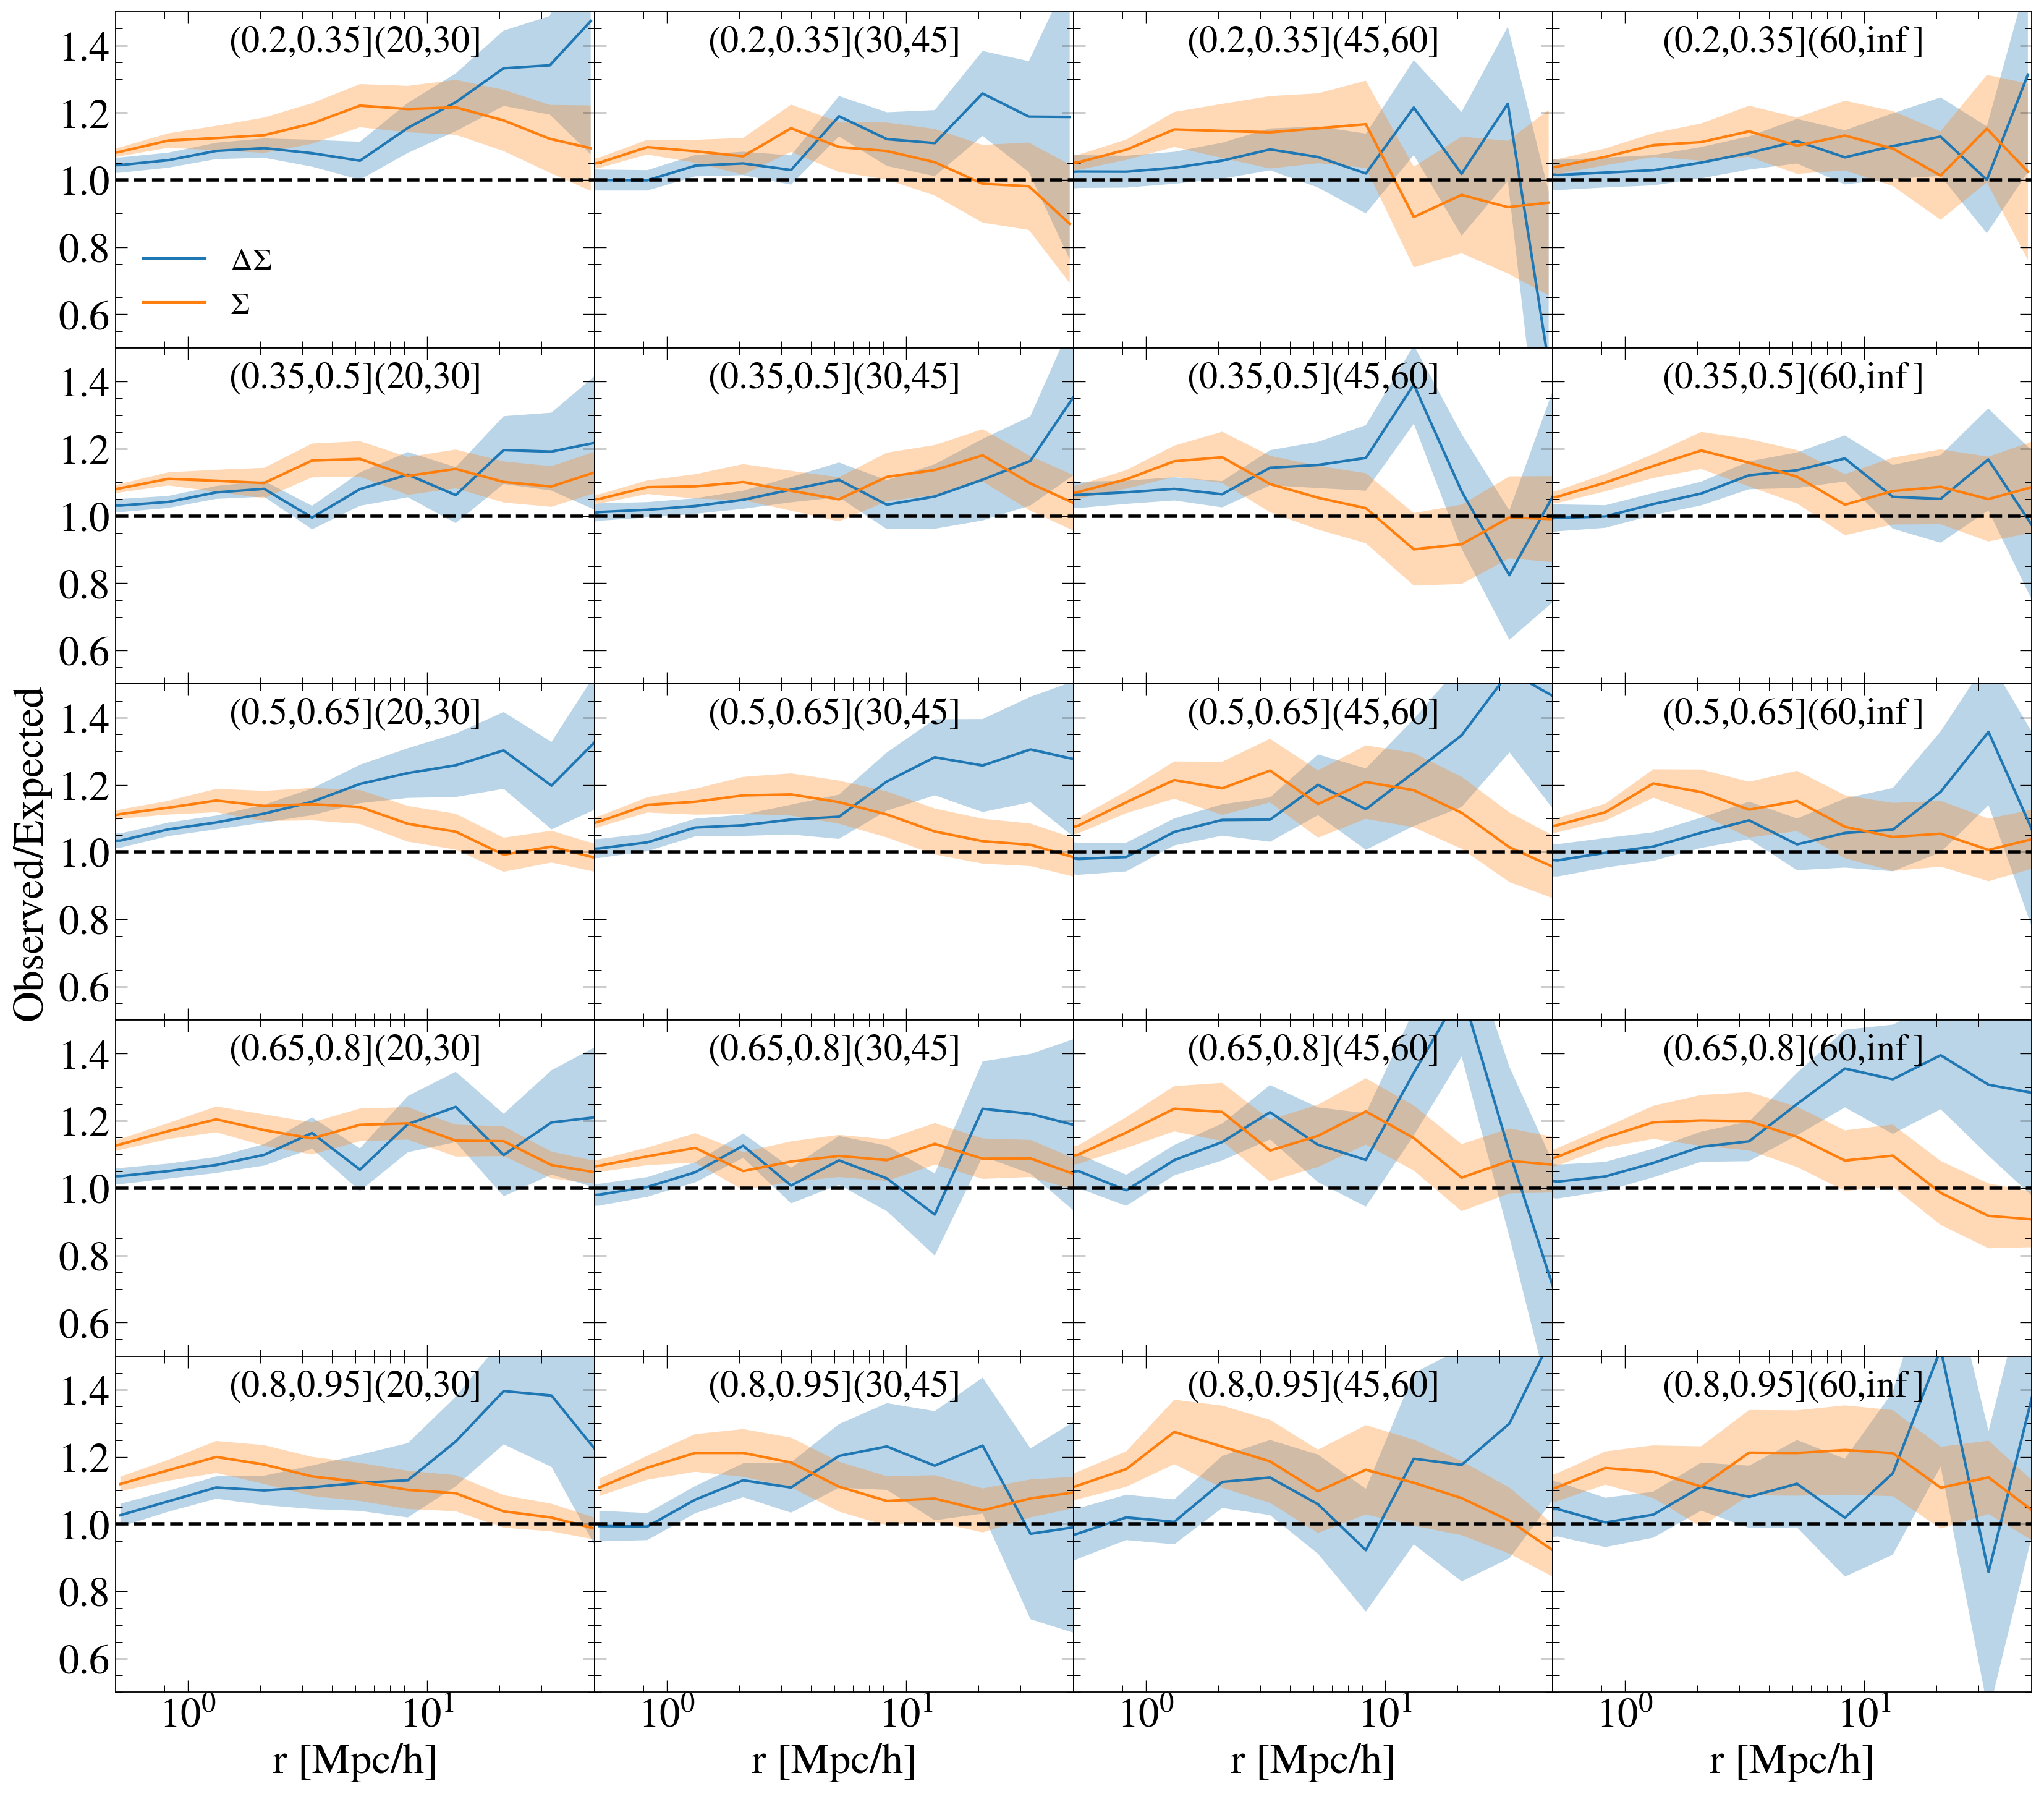

In [35]:
from matplotlib.ticker import MaxNLocator

def error_propagation_ratio(ratio_sel_exp, sel_signal, err_sel_signal):
    err_ratio_sel_exp = ratio_sel_exp * np.sqrt((err_sel_signal / sel_signal)**2)
    return err_ratio_sel_exp

# Create a figure with subplots
fig, axes = plt.subplots(5, 4, figsize=(20, 18), sharex=True, sharey=True)
axes = axes.flatten()

# for ax in axes:   
#     ax.tick_params(axis='both', which='major', labelsize=16)

for i, lambda_group in enumerate(grouped_cl_halos_red.groups):
    lnM_sel_red = np.log10(lambda_group['baseDC2/sod_halo_mass_y'])
    z_sel_red = lambda_group['redshift_y']
    profile_sel_red = lambda_group['sigma_y']
    bins = lambda_group['radius_y']
    profile_sel_ds_red = lambda_group['DS_y']
    
    # Extracting the z_range from lambda_group
    z_range = lambda_group['z_range'][0]
    lambda_range = lambda_group['lambda_range'][0]
    z_min, z_max = map(float, z_range.strip('()[]').split(','))

    underlying_halos = sigma_ds_profile_old[(sigma_ds_profile_old['redshift'] >= z_min) & (sigma_ds_profile_old['redshift'] < z_max)]
    lnM_All = np.log10(underlying_halos['baseDC2/sod_halo_mass'])
    z_All = underlying_halos['redshift']
    profile_All = underlying_halos['sigma']
    profile_All_ds = underlying_halos['DS']
    
    expected_ds_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_ds_red, lnM_All, z_All, profile_All_ds)
    expected_sigma_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_red, lnM_All, z_All, profile_All)

    ratio_ds_red = np.array(profile_sel_ds_red.mean(axis=0)) / np.array(expected_ds_red)
    ratio_sigma_red = np.array(profile_sel_red.mean(axis=0)) / np.array(expected_sigma_red)
    
#     ### Error
    # err_sel_signal = ds_err[(ds_err['lambda_range']==lambda_range) & (ds_err['z_range']==z_range)]
    err_ds_red = ds_err[(ds_err['lambda_range']==lambda_range) & (ds_err['z_range']==z_range)] 
    #error_propagation_ratio(ratio_ds_red,profile_sel_ds_red.mean(axis=0),err_sel_signal)
    #ds_err['std_deltasigma'][(ds_err['lambda_range']==lambda_range) & (ds_err['z_range']==z_range)] / np.array(expected_ds_red)
    err_sigma_red = s_err[(s_err['lambda_range']==lambda_range) & (s_err['z_range']==z_range)] 
    
    axes[i].plot(np.mean(bins,axis=0), ratio_ds_red, label='$\Delta\Sigma$')
    axes[i].fill_between(err_sigma_red['radius'][0], ratio_ds_red-(err_ds_red['sem'][0]/ np.array(expected_ds_red)), ratio_ds_red+(err_ds_red['sem'][0]/ np.array(expected_ds_red)), alpha=0.3)
    
    axes[i].plot(np.mean(bins,axis=0), ratio_sigma_red, label='$\Sigma$')
    axes[i].fill_between(err_sigma_red['radius'][0], ratio_sigma_red-(err_sigma_red['sem'][0]/ np.array(expected_sigma_red)), ratio_sigma_red+(err_sigma_red['sem'][0]/ np.array(expected_sigma_red)), alpha=0.3) 

    axes[i].axhline(y=1, color='black', linestyle='--', linewidth=2)
    
    axes[i].set_title(f'{z_range}{lambda_range}', y=0.851)
    axes[i].set_xlabel('r [Mpc/h]', fontsize=25)
    axes[i].set_xscale('log')
    axes[i].set_ylim(0.5,1.5)
    axes[i].set_xlim(0.5,50)
    axes[i].tick_params(axis='both', which='major', labelsize=24) 

    if i % 4 >= 1:
        axes[i].yaxis.set_major_locator(MaxNLocator(nbins=6,prune='upper'))
        
    axes[i].grid(visible=False)
    axes[0].legend(loc='lower left',frameon = False)
    
axes[0].set_ylabel('Observed/Expected',position=(0, -1.5), fontsize=25)

plt.subplots_adjust(hspace=0, wspace=0)
filep = r'/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/'
plt.savefig(filep + 'Images/skysim_sel_bias.png', facecolor='white')
plt.show()

In [14]:
# cluster_halo_1 = pd.merge(sigma_ds_profile,cluster_1, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
# cluster_halo_30 = pd.merge(sigma_ds_profile,cluster_30, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
# cluster_halo_60 = pd.merge(sigma_ds_profile,cluster_60, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
# cluster_halo_90 = pd.merge(sigma_ds_profile,cluster_90, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
# cluster_halo_120 = pd.merge(sigma_ds_profile,cluster_120, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
# print(len(cluster_halo_1), len(cluster_halo_30),len(cluster_halo_60),len(cluster_halo_90),len(cluster_halo_120))
# print(len(cluster_1), len(cluster_30),len(cluster_60),len(cluster_90),len(cluster_120))


# # Create a figure with subplots
# fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharex=True, sharey=True)

# for lambda_group in sorted(grouped_cl_halos_red.groups.keys(), reverse=True):
#     sel_clusters_red = grouped_cl_halos_red.get_group(lambda_group)
#     lnM_sel_red = np.log10(sel_clusters_red['baseDC2/sod_halo_mass'])
#     z_sel_red = sel_clusters_red['redshift']
#     profile_sel_red = sel_clusters_red['sigma']
#     profile_sel_ds_red = sel_clusters_red['DS']

#     num_clusters_in_bin = len(sel_clusters_red)
    
#     sel_clusters_1 = cluster_halo_1.nlargest(num_clusters_in_bin, 'lam') # Select the top clusters from cluster_halo_30 based on halo_mass
#     # sel_clusters_1 = sel_clusters_1[sel_clusters_1['baseDC2/sod_halo_mass']>0]
#     cluster_halo_1 = cluster_halo_1.drop(sel_clusters_1.index) # Remove the selected clusters from cluster_halo_30 to avoid duplicates
#     lnM_sel_1 = np.log10(sel_clusters_1['baseDC2/sod_halo_mass'])
#     z_sel_1 = sel_clusters_1['redshift_y']
#     profile_sel_1 = sel_clusters_1['sigma']
#     profile_sel_ds_1 = sel_clusters_1['DS']
    
#     sel_clusters_30 = cluster_halo_30.nlargest(num_clusters_in_bin, 'lam') # Select the top clusters from cluster_halo_30 based on halo_mass
#     # sel_clusters_30 = sel_clusters_30[sel_clusters_30['baseDC2/sod_halo_mass']>0]
#     cluster_halo_30 = cluster_halo_30.drop(sel_clusters_30.index) # Remove the selected clusters from cluster_halo_30 to avoid duplicates
#     lnM_sel_30 = np.log10(sel_clusters_30['baseDC2/sod_halo_mass'])
#     # print('{:e}'.format(np.max((sel_clusters_30['baseDC2/sod_halo_mass']))))
#     # print((sel_clusters_30['baseDC2/sod_halo_mass']>1e15).sum())
#     z_sel_30 = sel_clusters_30['redshift_y']
#     profile_sel_30 = sel_clusters_30['sigma']
#     profile_sel_ds_30 = sel_clusters_30['DS']
    
    
#     sel_clusters_60 = cluster_halo_60.nlargest(num_clusters_in_bin, 'lam')
#     # sel_clusters_60 = sel_clusters_60[sel_clusters_60['baseDC2/sod_halo_mass']>0]
#     cluster_halo_60 = cluster_halo_60.drop(sel_clusters_60.index)
#     lnM_sel_60 = np.log10(sel_clusters_60['baseDC2/sod_halo_mass'])
#     z_sel_60 = sel_clusters_60['redshift_y']
#     profile_sel_60 = sel_clusters_60['sigma']
#     profile_sel_ds_60 = sel_clusters_60['DS']

    
#     underlying_halos = sigma_ds_profile[(sigma_ds_profile['redshift']>=0.2) & (sigma_ds_profile['redshift']<0.35)]
#     lnM_All = np.log10(underlying_halos['baseDC2/sod_halo_mass'])
#     z_All = underlying_halos['redshift']
#     profile_All = underlying_halos['sigma']
#     profile_All_ds = underlying_halos['DS']
    
#     # Extract numerical values from redshift and lambda group labels
#     # redshift_value = float(re.findall(r'\d+\.\d+', redshift_group)[0])
#     lambda_value = float(re.findall(r'\d+', lambda_group)[0])
    

#     # Calculate the row and column indices for the subplot
#     col_index = int(lambda_value) // 15 - 1
#     row_index = 2

#     axes[col_index].hist(np.log10(sel_clusters_red['baseDC2/sod_halo_mass']), alpha=0.5, label='redmapper', rwidth=1)
#     axes[col_index].hist(lnM_sel_1, alpha=0.5, label='depth 1', rwidth=1)
#     axes[col_index].hist(lnM_sel_30, alpha=0.5, label='depth 30', rwidth=1)
#     axes[col_index].hist(lnM_sel_60, alpha=0.5, label='depth 60', rwidth=1)
#     axes[col_index].hist(lnM_sel_90, alpha=0.5, label='depth 90', rwidth=1)
#     axes[col_index].hist(lnM_sel_120, alpha=0.5, label='depth 120', rwidth=1)

#     axes[col_index].set_yscale('log')
    
#     axes[0].legend(loc='best')

#     # Set the title inside the subplot
#     title = f'z(0.2,0.35] $\lambda${lambda_group}'
#     title_y = 1.1 if row_index > 3 else 0.9  # Adjust the y position for the last row
#     axes[col_index].set_title(title,  loc='right', y=title_y)


# # Adjust the spacing between subplots
# plt.subplots_adjust(hspace=0, wspace=0)


# # Set the x and y-axis labels for the bottom subplots
# for ax in axes[:]:
#     ax.set_xlabel('Mass') #r [Mpc]

# plt.show()

In [15]:
# cluster_halo_1 = pd.merge(sigma_ds_profile,cluster_1, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
# cluster_halo_1 = cluster_halo_1[cluster_halo_1['baseDC2/sod_halo_mass']>0]
# cluster_halo_30 = pd.merge(sigma_ds_profile,cluster_30, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
# cluster_halo_30 = cluster_halo_30[cluster_halo_30['baseDC2/sod_halo_mass']>0]
# cluster_halo_60 = pd.merge(sigma_ds_profile,cluster_60, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
# cluster_halo_60 = cluster_halo_60[cluster_halo_60['baseDC2/sod_halo_mass']>0]
# cluster_halo_90 = pd.merge(sigma_ds_profile,cluster_90, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
# cluster_halo_90 = cluster_halo_90[cluster_halo_90['baseDC2/sod_halo_mass']>0]
# cluster_halo_120 = pd.merge(sigma_ds_profile,cluster_120, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
# cluster_halo_120 = cluster_halo_120[cluster_halo_120['baseDC2/sod_halo_mass']>0]
# print(len(cluster_halo_1), len(cluster_halo_30),len(cluster_halo_60),len(cluster_halo_90),len(cluster_halo_120))
# print(len(cluster_1), len(cluster_30),len(cluster_60),len(cluster_90),len(cluster_120))

In [16]:
# fig, axes = plt.subplots(1,5, figsize=(10,5))
# axes[0].hist(np.log10(cluster_halo_1['baseDC2/sod_halo_mass']), alpha=0.2, label='D1')
# axes[0].set_yscale('log')
# axes[0].legend()
# axes[1].hist(np.log10(cluster_halo_30['baseDC2/sod_halo_mass']), alpha=0.2, label='D30')
# axes[1].set_yscale('log')
# axes[1].legend()
# axes[2].hist(np.log10(cluster_halo_60['baseDC2/sod_halo_mass']), alpha=0.2, label='D60')
# axes[2].set_yscale('log')
# axes[2].legend()
# axes[3].hist(np.log10(cluster_halo_90['baseDC2/sod_halo_mass']), alpha=0.2, label='D90')
# axes[3].set_yscale('log')
# axes[3].legend()
# axes[4].hist(np.log10(cluster_halo_120['baseDC2/sod_halo_mass']), alpha=0.2, label='D120')
# plt.yscale('log')
# plt.legend()
# plt.show()

In [17]:
# fig, axes = plt.subplots(1,4, figsize=(10,5))
# axes[0].hist(np.log10(cluster_halo_30['mass']), alpha=0.2)
# axes[0].set_yscale('log')
# axes[1].hist(np.log10(cluster_halo_60['mass']), alpha=0.2)
# axes[1].set_yscale('log')
# axes[2].hist(np.log10(cluster_halo_90['mass']), alpha=0.2)
# axes[2].set_yscale('log')
# axes[3].hist(np.log10(cluster_halo_120['mass']), alpha=0.2)
# plt.yscale('log')

In [18]:
# fig, axes = plt.subplots(1,4, figsize=(10,5))
# axes[0].hist(np.log10(cluster_30['mass']), alpha=0.2)
# axes[0].set_yscale('log')
# axes[1].hist(np.log10(cluster_60['mass']), alpha=0.2)
# axes[1].set_yscale('log')
# axes[2].hist(np.log10(cluster_90['mass']), alpha=0.2)
# axes[2].set_yscale('log')
# axes[3].hist(np.log10(cluster_120['mass']), alpha=0.2)
# plt.yscale('log')

In [19]:
# fig, axes = plt.subplots(1,4, figsize=(10,5))
# axes[0].hist(np.log10(cluster_halo_30['halo_mass']), alpha=0.2)
# axes[0].set_yscale('log')
# axes[1].hist(np.log10(cluster_halo_60['halo_mass']), alpha=0.2)
# axes[1].set_yscale('log')
# axes[2].hist(np.log10(cluster_halo_90['halo_mass']), alpha=0.2)
# axes[2].set_yscale('log')
# axes[3].hist(np.log10(cluster_halo_120['halo_mass']), alpha=0.2)
# plt.yscale('log')